Importing Packages and Basic Set-up

In [87]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss

import numpy as np
import pandas as pd
from plotnine import *

Importing Datasets and Merging

In [3]:
# Importing maindata
file_path = "C://Users/soren/Downloads/"
x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Dataset

In [88]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int


# indicator for if treatment has occured in state i
basic_merged["year_indic"] = (basic_merged["year"] >= basic_merged["Year_Implemented"]) 

# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]

Defining a Confounders Set

In [ ]:
# Generating list of confounders of interest, these are still not optimal
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]

Defining a Function to Perform KFold Predictions

In [89]:
# Slightly Modified version of the kfold function Gloria wrote - it might be worth seeing if it can
# be optimized to run faster so we can test more models
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, y1:int, y0:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''

    # Setting up a prediction matrix
    predictions = np.empty((y.shape[0],4))
    predictions[:] = np.nan

    kf = KFold(n_splits=n_splits, shuffle=True)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point
    X0_y1 = X_w_treatment.copy()
    X0_y1["A"] = 0
    X0_y1["year"] = y1

    X1_y1 = X_w_treatment.copy()
    X1_y1["A"] = 1
    X1_y1["year"] = y1

    X0_y0 = X_w_treatment.copy()
    X0_y0["A"] = 0
    X0_y0["year"] = y0

    X1_y0 = X_w_treatment.copy()
    X1_y0["A"] = 1
    X1_y0["year"] = y0

    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    for train_index, test_index in kf.split(X_w_treatment, y):
        q = make_model()
        q.fit(X_w_treatment.loc[train_index], y.loc[train_index])

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1
        treat_vec[test_index] = A.loc[test_index]

        predictions[test_index,0] = q.predict_proba(X0_y1.loc[test_index])[:, 1]
        predictions[test_index,1] = q.predict_proba(X1_y1.loc[test_index])[:, 1]
        predictions[test_index,2] = q.predict_proba(X0_y0.loc[test_index])[:, 1]
        predictions[test_index,3] = q.predict_proba(X1_y0.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0  # Sanity check that we have no missings
    return predictions[:,1], predictions[:,3], predictions[:,0], predictions[:,2], year_vec, treat_vec

Define a Function to Get the Overall Casual Effects

In [104]:
# General function to return the casual effect for a specific year, state, ect.
def get_att(state_fips,confounder_list, treat_year, g_d_1, model_list, dataframe, responses):
    '''
    state_fips: an integer corresponding to the fips number of the state being tested
    confounder_list: a list of the columns names of the desired confounders
    treat_year: the year the state implemented its policy
    g_d_1: the year to be compared to
    model_list: a list of q models to use
    dataframe: a dataframe to take the data for the year, confounder, and response from must have columns named
                for each of the confounders and ["under19", "treatment", "pubonly", "insured", "privonly", "Year_Implemented","State_Name"]
    responses: the desired target effect - choose one or more from ["insured","pubonly", "privonly"]

    returns: a dataframe where each row corresponds to a different casaul effect with column names for the
                year measured, treatment year, casual effect, standard deviation of casual effect, state ID
                state name, q model used, and target response
    '''
                                                    
    results_df = {}

    state_level = dataframe[confounder_list + ["under19", "treatment", "pubonly", "insured", "privonly", "Year_Implemented","State_Name"]]
    state_level = state_level[state_level["stfips"] == state_fips]
    state_level = state_level.dropna(axis = 0)
    state_level["year"] = state_level["year"] - g_d_1 # Normalizing for interpretability. 
                                                # t = 1 is when treatment occurs first

    state_name = state_level["State_Name"].values[0]

    state_level = state_level.reset_index(drop=True)

    for i in range(1992, 2009):  # We compute the ATT for each year

        top_year = i - (treat_year - 1)  # Normalizing for interpretability (t = 1 is when treatment occurs)
        # For any year prior to treatment (like 1995), it says we should compare that year (t = t') to the prior year (t = t' - 1)
        
        if top_year >= 1:
            base_year = 0  # This is the year right before treatment (i.e. g_d_1 from above)
        else:
            base_year = top_year - 1

        for response in responses:
            for model in model_list:
                
                # Setting up 
                confounders = state_level[confounder_list]
                treatment = state_level['treatment']
                outcome = state_level[response]

                # Fitting
                term_1, term_2, term_3, term_4, year_vec, treat_vec = outcome_k_fold_fit_and_predict(model, \
                                                    X=confounders, y=outcome, A=treatment,  n_splits=5, \
                                                    y1=top_year, y0=base_year)
                weight = (year_vec == 1) * (treat_vec == 1) # We only want the ATT, so we weight appropriately
                                                            # to only look at the untils treated at t=1
                weight = weight / np.mean(weight)
                final = weight * (term_1 - term_2 - (term_3 - term_4))

                # Multiplying by 100 to convert to %
                std = np.std(final) / np.sqrt(term_1.shape[0]) * 1.96 * 100  # the ".shape" part is just to get the right n
                mean = np.mean(final) * 100

                # would like to add a column for the out of sample accuracy of the q model but don't know how to do that
                # accuracy = sum(errors)/len(errors)

                # Adding a value to each row for each desired column
                results_df.setdefault('year',[]).append(i)
                results_df.setdefault('att',[]).append(mean)
                results_df.setdefault('std',[]).append(std)
                results_df.setdefault('ID',[]).append(state_fips)
                results_df.setdefault('State',[]).append(state_name)
                results_df.setdefault('model',[]).append(model.__name__ )
                results_df.setdefault('response',[]).append(response)
                results_df.setdefault('treat_year',[]).append(treat_year)

                # column for the out of sample accuracy of the q model
                #results_df.setdefault('accuracy',[]).append(accuracy)

    results_df = pd.DataFrame(results_df)

    return results_df

Define Q Models to Use

In [150]:
# These are not necessarily optimal
# I just define them to give a sense of how the above functions can be used with multipe Q models

def slim_forest():
    '''An extremely over-simplified function to use to test code so that it runs quickly'''
    return RandomForestClassifier(max_depth=2, n_estimators=10)

def slim_grad():
    '''An extremely over-simplified function to use to test code so that it runs quickly'''
    return GradientBoostingClassifier(max_depth=2, n_estimators=10, learning_rate = 10)

def foresta():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(max_depth=1, n_estimators=100)

def forestb():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(max_depth=10, n_estimators=100)

def forestc():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(max_depth=100, n_estimators=100)

def adaa():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return AdaBoostClassifier(n_estimators=10)

def adab():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return AdaBoostClassifier(n_estimators=100)

def adac():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return AdaBoostClassifier(n_estimators=1000)

def grada():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return GradientBoostingClassifier(max_depth=1, n_estimators=100)

def gradb():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return GradientBoostingClassifier(max_depth=10, n_estimators=100)
    
def gradc():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return GradientBoostingClassifier(max_depth=100, n_estimators=100)

Basic Function Use

In [105]:
# Estimating the att for one state, one model

models_to_use = [forestb]
simple_att = get_att(16, list_of_confounders,1997,1996, models_to_use, basic_merged,["insured"])
simple_att.head()

,year,att,std,ID,State,model,response,treat_year
0,1992,-1.000882,0.390317,16,ID,forestb,insured,1997
1,1993,-0.723583,0.233436,16,ID,forestb,insured,1997
2,1994,0.560882,0.259144,16,ID,forestb,insured,1997
3,1995,0.633806,0.204886,16,ID,forestb,insured,1997
4,1996,0.793324,0.245065,16,ID,forestb,insured,1997


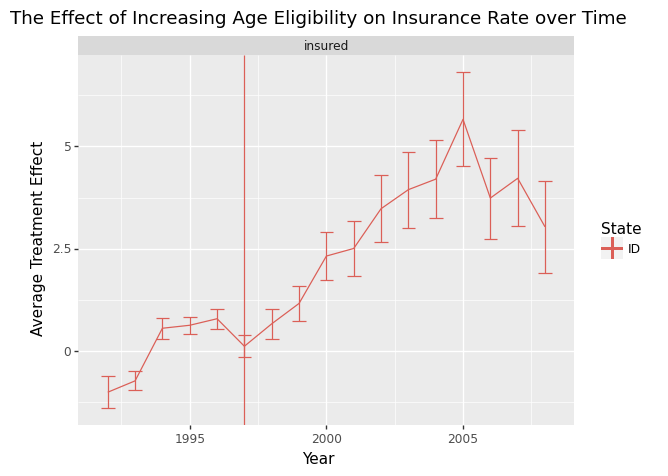

<ggplot: (110606579637)>

In [106]:
# Plotnine code to visualize results

simple_att['att-error'] = simple_att['att'] - simple_att['std']
simple_att['att+error'] = simple_att['att'] + simple_att['std']
ggplot(simple_att, aes(x='year', y='att', color = 'State')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect') + \
labs(title = "The Effect of Increasing Age Eligibility on Insurance Rate over Time") + \
geom_vline(aes(xintercept = 'treat_year', color = "State"))


Computing the Effects for all States

In [109]:
# Evaluate the ATT's for all the states which implemented programs after 1997

# Get all years (other than never) that states implemented programs
law_years = np.sort(basic_merged['Year_Implemented'].unique())[:-1]

all_state_df = pd.DataFrame()

models_to_use = [slim_forest]

for year in law_years:

    # Get all states which implemented programs in that year
    states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

    # Do the analysis for each state in a year
    for state in states_in_year:

        new_state = get_att(int(state), list_of_confounders,year,year-1, models_to_use, basic_merged, ["insured","pubonly", "privonly"])
        
        all_state_df = pd.concat([all_state_df, new_state], ignore_index=True)

all_state_df.head()

,year,att,std,ID,State,model,response,treat_year
0,1992,0.000000e+00,8.019164e-16,9,CT,slim_forest,insured,1997
1,1992,0.000000e+00,0.000000e+00,9,CT,slim_forest,pubonly,1997
2,1992,-4.975067e-02,4.359313e-02,9,CT,slim_forest,privonly,1997
3,1993,5.104774e-02,5.775383e-02,9,CT,slim_forest,insured,1997
4,1993,4.429081e-17,1.193045e-16,9,CT,slim_forest,pubonly,1997


C:\Users\soren\AppData\Local\Temp\ipykernel_26556\2011970469.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


   treat_year  adjusted_year  response    year       att       std         ID  \
0        1997             -5   insured  1992.0 -0.082518  0.078811  32.777778   
1        1997             -5  privonly  1992.0  0.032487  0.025024  32.777778   
2        1997             -5   pubonly  1992.0  0.012881  0.008154  32.777778   
3        1997             -4   insured  1993.0  0.044937  0.061059  32.777778   
4        1997             -4  privonly  1993.0  0.030377  0.041779  32.777778   

   att-error  att+error  
0  -0.161329  -0.003707  
1   0.007463   0.057510  
2   0.004727   0.021035  
3  -0.016122   0.105996  
4  -0.011402   0.072156  


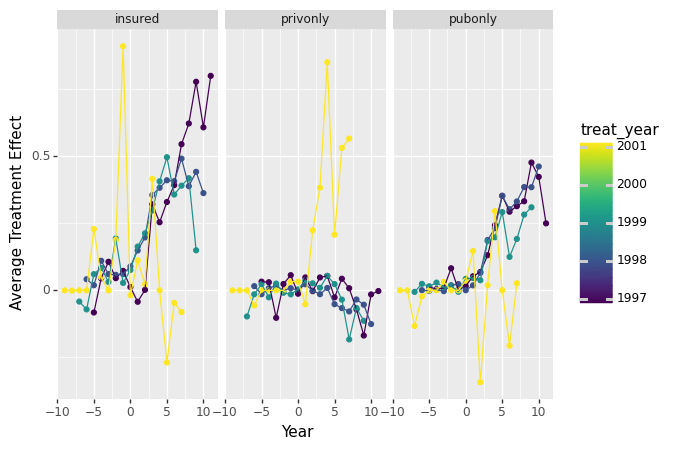

<ggplot: (110609500657)>

In [116]:
# Plotnine code to visualize the results

all_state_df['att-error'] = all_state_df['att'] - all_state_df['std']
all_state_df['att+error'] = all_state_df['att'] + all_state_df['std']
all_state_df['adjusted_year'] = all_state_df["year"] - all_state_df["treat_year"]
all_state_df['treat_year'] = pd.to_numeric(all_state_df['treat_year'])
states_by_year = all_state_df.groupby(['treat_year','adjusted_year', 'response'],as_index=False).mean()
print(states_by_year.head())
ggplot(states_by_year, aes(x='adjusted_year', y='att', color = 'treat_year', group='treat_year')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect')
#geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \

Comparing Different Model Types

In [148]:
# Testing how varying the model changes the results for Idaho
# Running this still takes too long to do properly

models_to_use = [slim_forest, slim_grad]
diff_models = get_att(16, list_of_confounders,1997,1996, models_to_use, basic_merged,["insured","pubonly", "privonly"])

In [149]:
print(diff_models.head())

   year  att  std  ID State        model  response  treat_year
0  1992  0.0  0.0  16    ID  slim_forest   insured        1997
1  1992  0.0  0.0  16    ID    slim_grad   insured        1997
2  1992  0.0  0.0  16    ID  slim_forest   pubonly        1997
3  1992  0.0  0.0  16    ID    slim_grad   pubonly        1997
4  1992  0.0  0.0  16    ID  slim_forest  privonly        1997


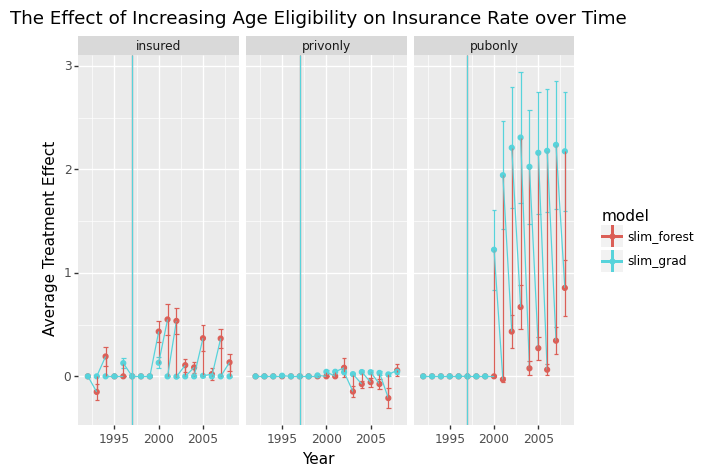

<ggplot: (110606834137)>

In [142]:
# Plotnine code to visualize results
# This plot looks wierd since I estimated it with overly small models

diff_models['att-error'] =diff_models['att'] - diff_models['std']
diff_models['att+error'] = diff_models['att'] + diff_models['std']
ggplot(diff_models, aes(x='year', y='att', color = 'model', group='treat_year')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect') + \
labs(title = "The Effect of Increasing Age Eligibility on Insurance Rate over Time") + \
geom_vline(aes(xintercept = 'treat_year', color = "model"))

Parallel Trends Check

In [15]:
# Evaluate the ATT's for all the states which implemented programs after 1997 increasing the treatment year by 1

# Get all years (other than never) that states implemented programs
law_years = np.sort(basic_merged['Year_Implemented'].unique())[:-1]

all_state_df = pd.DataFrame()

models_to_use = [slim_forest]

for year in law_years:

    # Get all states which implemented programs in that year
    states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

    # Do the analysis for each state in a year
    for state in states_in_year:

        # Simply change the year implemented to the year after it actually was and chage g_d_1 likewise
        new_state = get_att(int(state), list_of_confounders,year+1,year, models_to_use, basic_merged, ["insured","pubonly", "privonly"])
        
        all_state_df = pd.concat([all_state_df, new_state], ignore_index=True)

all_state_df.head()

array([ 1.,  5.,  6.,  8., 11., 12., 17., 19., 21., 22., 24., 26., 27.,
       28., 29., 31., 32., 33., 34., 37., 38., 39., 46., 48., 49.])

In [ ]:
# Plotnine code to visualize the results

all_state_df['att-error'] = all_state_df['att'] - all_state_df['std']
all_state_df['att+error'] = all_state_df['att'] + all_state_df['std']
all_state_df['adjusted_year'] = all_state_df["year"] - all_state_df["treat_year"]
all_state_df['treat_year'] = pd.to_numeric(all_state_df['treat_year'])
states_by_year = all_state_df.groupby(['treat_year','adjusted_year', 'response'],as_index=False).mean()
print(states_by_year.head())
ggplot(states_by_year, aes(x='adjusted_year', y='att', color = 'treat_year', group='treat_year')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect')
#geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \

Placebo Analysis

In [ ]:
# Doing a placebo analysis to see if states which never implemented still show casual effect

# Get the year assigned to never
law_years = np.sort(basic_merged['Year_Implemented'].unique())[-1]

all_state_df = pd.DataFrame()

models_to_use = [slim_forest]

for year in law_years:

    # Get all states which implemented programs in that year
    states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

    # Do the analysis for each state in a year
    for state in states_in_year:

        # Pretend that treatment occured in 1997
        new_state = get_att(int(state), list_of_confounders,1997,1996, models_to_use, basic_merged, ["insured","pubonly", "privonly"])
        
        all_state_df = pd.concat([all_state_df, new_state], ignore_index=True)

all_state_df.head()

In [ ]:
# Plotnine code to visualize the results

all_state_df['att-error'] = all_state_df['att'] - all_state_df['std']
all_state_df['att+error'] = all_state_df['att'] + all_state_df['std']
all_state_df['adjusted_year'] = all_state_df["year"] - all_state_df["treat_year"]
all_state_df['treat_year'] = pd.to_numeric(all_state_df['treat_year'])
states_by_year = all_state_df.groupby(['treat_year','adjusted_year', 'response'],as_index=False).mean()
print(states_by_year.head())
ggplot(states_by_year, aes(x='adjusted_year', y='att', color = 'treat_year', group='treat_year')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect')